In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import LabelEncoder
import gc
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Dense, Add, Input, Flatten, Lambda
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plot
import seaborn as sn
import pickle

In [ ]:
#  uncomment following codes for creating shortened text dataset from original tatoeba dataset
# df = pd.read_csv('./dataset/sentences.csv', sep='\t', 
#                             encoding='utf8', 
#                             index_col=0,
#                             names=['lang','text'])

In [2]:
LANGUAGE_LIST = ['eng','fra', 'spa','ita','deu']
SENTENCE_PER_LANG_FOR_DATASET = 100000
CHAR_PER_SENTENCE = 50
VAL_SENTENCES = 25000
TEST_SENTENCES = 25000 
NULL_CHAR = '<None>'

In [ ]:
# filtered_df = pd.DataFrame(columns=df.columns)
# for l in LANGUAGE_LIST:
#     filtered_df = pd.concat([filtered_df, 
#                             df[df['lang'] == l].sample(
#                                 SENTENCE_PER_LANG_FOR_DATASET)])
# filtered_df.describe()

In [ ]:
# shortened_rows_list = []
# for index, row in filtered_df.iterrows():
#     words = row["text"].split(' ')
#     currRow = ''
#     for word in words:
#         if len(word) > CHAR_PER_SENTENCE:
#             continue
#         if len(currRow + ' ' + word) > CHAR_PER_SENTENCE:
#             shortened_rows_list.append({
#                 'text': currRow,
#                 'lang': row["lang"]
#             })
#             currRow = word
#         else:
#             currRow = currRow + ' ' + word
#     if currRow != '':
#         shortened_rows_list.append({
#             'text': currRow,
#             'lang': row["lang"]
#         })
# shortened_df = pd.DataFrame(data=shortened_rows_list, columns=df.columns)
# shortened_df = shortened_df.drop_duplicates(subset='text')

In [ ]:
# shortened_df.to_csv('./dataset/shortened-sentences.csv')

In [7]:
df = pd.read_csv('./dataset/shortened-sentences.csv', index_col=0)
df.describe()

,lang,text
count,600468,600468
unique,5,600468
top,deu,Où est ton chapeau ?
freq,134471,1


In [ ]:
vocab_set = set()
for text in df['text']:
    for char in text:
        vocab_set.add(char)
vocab = list(vocab_set)
vocab.append('<None>')
vocab_encoder = LabelEncoder()
vocab_encoder.fit(vocab)

In [ ]:
len(vocab)
vocab.append('<None>')

In [ ]:
shuffled_df = df.sample(frac=1)
val_df = shuffled_df[:VAL_SENTENCES]
test_df = shuffled_df[VAL_SENTENCES:VAL_SENTENCES + TEST_SENTENCES]
train_df = shuffled_df[VAL_SENTENCES+TEST_SENTENCES:]

In [ ]:
del vocab_set,vocab_encoder,df, shuffled_df
gc.collect()

In [ ]:
vocab_encoder = LabelEncoder()
vocab_encoder.fit(vocab)
label_encoder = LabelEncoder()
label_encoder.fit(LANGUAGE_LIST)

In [3]:
def text_to_vector(text):
    char_list = list(text)
    char_list = [NULL_CHAR]*(CHAR_PER_SENTENCE - len(text)) + char_list
    labels = vocab_encoder.transform(char_list)
    return labels

In [6]:
def data_generator(dataset_df, batch_size):
    no_of_batches = len(dataset_df) // batch_size
    batches = np.array_split(dataset_df, no_of_batches)
    i = 0;
    while True:
        batch = batches[i]
        i += 1
        i %= no_of_batches
        x = np.stack(list(map(text_to_vector,batch['text'])))
        y = to_categorical(label_encoder.transform(batch['lang']),num_classes=len(LANGUAGE_LIST))
        yield x,y            

In [ ]:
train_generator = data_generator(train_df,5)
x,y = next(train_generator)
print(x)
print(x.shape)
print(y)
print(y.shape)

In [ ]:
batch_size = 64
train_generator = data_generator(train_df, batch_size)
val_generator = data_generator(val_df, batch_size)
train_steps_per_epoch = len(train_df) // batch_size
val_steps_per_epoch = len(val_df) // batch_size

In [ ]:
input_layer = Input(shape=(CHAR_PER_SENTENCE,))
embedding_out = Embedding(len(vocab),150,input_length=CHAR_PER_SENTENCE)(input_layer)
lstm_layer = LSTM(150, return_sequences=True)
bidirectional_out = Bidirectional(lstm_layer)(embedding_out)
flat_out = Flatten()(bidirectional_out)
dense_out = Dense(len(LANGUAGE_LIST),activation='softmax')(flat_out)
model = Model(input_layer,dense_out)
model.summary()

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_generator,
          steps_per_epoch=train_steps_per_epoch,
          validation_data=val_generator,
          validation_steps=val_steps_per_epoch,
          epochs=4)
         

In [ ]:
model.save('./models/apple-bi-lstm.model')

In [ ]:
preprocessing_objects = {
    'label_encoder': label_encoder,
    'vocab_encoder': vocab_encoder
}
pickle.dump(preprocessing_objects, open('./models/apple-bi-lstm-preprocessing-objects.pkl','wb'))

In [4]:
# load model for testing
gc.collect()
model = load_model('./models/apple-bi-lstm.model')
preprocessing_objects = pickle.load(open('./models/apple-bi-lstm-preprocessing-objects.pkl','rb'))
vocab_encoder = preprocessing_objects['vocab_encoder']
label_encoder = preprocessing_objects['label_encoder']

2021-07-24 14:43:01.911493: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-24 14:43:02.224378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-24 14:43:02.225018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.2415GHz coreCount: 3 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 13.41GiB/s
2021-07-24 14:43:02.225118: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-24 14:43:02.238373: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-24 14:43:02.238512: I tensorflow/stream_executor/platfor

In [5]:
# manual testing
sentence = 'je vais'
vector = text_to_vector(sentence)
vector = np.reshape(vector, (1,CHAR_PER_SENTENCE))
y_pred = model.predict(vector)
y_label = np.argmax(y_pred)
y_lang = label_encoder.inverse_transform([y_label])
print(y_lang[0])

2021-07-24 14:43:10.362425: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-24 14:43:10.384164: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz
2021-07-24 14:43:10.939342: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-24 14:43:11.345037: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2021-07-24 14:43:11.420424: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


fra


2021-07-24 14:43:11.785506: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


In [14]:
def model_output_to_lang(outputs):
    labels = np.argmax(outputs,axis=1)
    return label_encoder.inverse_transform(labels)

In [16]:
def calculate_cf(my_model, allInput, allTarget):
    all_predictions = my_model.predict(allInput)
    test_target_lang=model_output_to_lang(allTarget)
    test_prediction_lang=model_output_to_lang(all_predictions)
    cf = confusion_matrix(test_target_lang,test_prediction_lang,labels=LANGUAGE_LIST)
    return cf

In [22]:
dataset_generator = data_generator(df, 100)
dataset_steps_per_epoch = len(df) // 100
data_input, data_target = next(dataset_generator)
cf = calculate_cf(model,data_input,data_target)
print(dataset_steps_per_epoch)
for i in range(dataset_steps_per_epoch - 1):
    print('=',end='')
    curr_input,curr_target = next(dataset_generator)
    cf += calculate_cf(model,curr_input, curr_target)
    if i%100 == 99:
        print("{0} done".format(i+1))

6004
====================================================================================================100 done
====================================================================================================200 done
====================================================================================================300 done
====================================================================================================400 done
====================================================================================================500 done
====================================================================================================600 done
====================================================================================================700 done
====================================================================================================800 done
====================================================================================================900 done
==============

In [25]:
print(np.sum(cf))
print(np.trace(cf))
print((np.sum(cf) - np.trace(cf))/np.sum(cf))
print(np.sum(cf) - np.trace(cf))

600468
596701
0.006273440050094259
3767


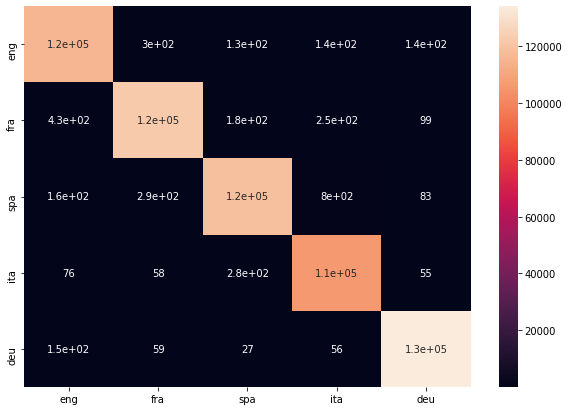

In [24]:
cf_df = pd.DataFrame(data=cf,columns=LANGUAGE_LIST,index=LANGUAGE_LIST)
plot.figure(figsize = (10,7))
sns_plot = sn.heatmap(cf_df, annot=True)
sns_plot.figure.savefig('./outputs/apple-bi-lstm.png')